In [4]:
%run ./00_template.py

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

LAYER_COMUNAS = "comunas_rm_censo"

# --- Inputs reales del pipeline actual (Notebook 03/04) ---
PARQ = OUTPUTS_DIR / "comunas_accessibility_otp.parquet"
LONG = OUTPUTS_DIR / "acc_long_partial.csv"

print("Notebook 05 – Síntesis (pipeline OTP)")
print("PARQ:", PARQ)
print("LONG:", LONG)

# --- Leer comunas y normalizar ID ---
comunas = gpd.read_file(RUTA_GPKG, layer=LAYER_COMUNAS).copy()
if "CUT_COM" in comunas.columns and "cod_comuna" not in comunas.columns:
    comunas = comunas.rename(columns={"CUT_COM": "cod_comuna"})
comunas["cod_comuna"] = comunas["cod_comuna"].astype(str)

# --- Cargar accesibilidad (ancha) desde parquet o reconstruir desde long ---
if PARQ.exists():
    acc = pd.read_parquet(PARQ)
else:
    acc = None

# Si no existe o está incompleto, reconstruimos desde LONG
if acc is None or acc.empty or len(acc) < 10:
    assert LONG.exists(), "❌ No existe acc_long_partial.csv. Vuelve al notebook 03 y genera el long."
    acc_long = pd.read_csv(LONG)
    acc_long["t_min_otp"] = pd.to_numeric(acc_long["t_min_otp"], errors="coerce")

    acc = acc_long.pivot_table(
        index=["cod_comuna", "comuna"],
        columns="categoria",
        values="t_min_otp",
        aggfunc="min"
    ).reset_index()

    acc.to_parquet(PARQ, index=False)
    print("✅ Parquet reconstruido:", PARQ)

# Tipos/normalización
acc["cod_comuna"] = acc["cod_comuna"].astype(str)
acc["comuna"] = acc["comuna"].astype(str)

# Features = columnas de accesibilidad (todas menos ids)
id_cols = {"cod_comuna", "comuna"}
FEATURES = [c for c in acc.columns if c not in id_cols]

print("✅ acc shape:", acc.shape)
print("✅ FEATURES:", FEATURES)
acc.head()


=== Template PEP1 Desiertos cargado ===
BASE_DIR        : /home/jovyan
CARGA_DIR       : /home/jovyan/data/raw/Carga de datos
RUTA_GPKG       : /home/jovyan/data/raw/Carga de datos/geodatabase_proyecto.gpkg
RUTA_CENSO_CSV  : /home/jovyan/data/raw/Carga de datos/censo_RM_totales_comuna.csv
Notebook 05 – Síntesis (pipeline OTP)
PARQ: /home/jovyan/outputs/comunas_accessibility_otp.parquet
LONG: /home/jovyan/outputs/acc_long_partial.csv
✅ acc shape: (48, 6)
✅ FEATURES: ['almacenes_barrio', 'educacion_superior', 'micro', 'salud']


,cod_comuna,comuna,almacenes_barrio,educacion_superior,micro,salud
0,13101,Santiago,3.616667,1.9,1.216667,4.800000
1,13102,Cerrillos,6.333333,NaN,2.600000,NaN
2,13103,Cerro Navia,NaN,NaN,5.083333,10.183333
3,13104,Conchalí,NaN,NaN,0.566667,NaN
4,13105,El Bosque,NaN,NaN,4.883333,3.400000


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Matriz X con features
X = acc[FEATURES].copy()

# Si hay NaN (comunas faltantes por OTP timeout), imputamos con "malo"
# Estrategia simple: rellenar con percentil 90 de cada feature
for col in FEATURES:
    p90 = np.nanpercentile(X[col].values, 90)
    X[col] = X[col].fillna(p90)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k_opt = 2
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)

df = acc.copy()
df["cluster"] = kmeans.fit_predict(X_scaled)

df[["cod_comuna", "comuna", "cluster"]].head()


,cod_comuna,comuna,cluster
0,13101,Santiago,1
1,13102,Cerrillos,0
2,13103,Cerro Navia,0
3,13104,Conchalí,0
4,13105,El Bosque,0


In [6]:
# Umbral de desierto (min). Ajustable
THRESH_MIN = 30.0

tabla = df.copy()

for col in FEATURES:
    tabla[f"es_desierto_{col}"] = (tabla[col].isna()) | (tabla[col] > THRESH_MIN)

bin_cols = [c for c in tabla.columns if c.startswith("es_desierto_")]
tabla["n_servicios_en_desierto"] = tabla[bin_cols].sum(axis=1)

tabla[["cod_comuna", "comuna", "cluster", "n_servicios_en_desierto"]].head()


,cod_comuna,comuna,cluster,n_servicios_en_desierto
0,13101,Santiago,1,0
1,13102,Cerrillos,0,2
2,13103,Cerro Navia,0,2
3,13104,Conchalí,0,3
4,13105,El Bosque,0,2


In [7]:
n_comunas = len(tabla)
promedio = tabla["n_servicios_en_desierto"].mean()
maxi = tabla["n_servicios_en_desierto"].max()
mini = tabla["n_servicios_en_desierto"].min()

print(f"Comunas analizadas: {n_comunas}")
print(f"Promedio servicios en desierto: {promedio:.2f}")
print(f"Máximo: {maxi}")
print(f"Mínimo: {mini}")


Comunas analizadas: 48
Promedio servicios en desierto: 2.44
Máximo: 4
Mínimo: 0


In [8]:
top_desiertos = tabla[["cod_comuna", "comuna", "cluster", "n_servicios_en_desierto"] + FEATURES] \
    .sort_values("n_servicios_en_desierto", ascending=False)

top_desiertos.head(15)


,cod_comuna,comuna,cluster,n_servicios_en_desierto,almacenes_barrio,educacion_superior,micro,salud
32,13302,Lampa,0,4,38.066667,NaN,NaN,36.233333
42,13505,San Pedro,0,4,NaN,NaN,NaN,46.783333
38,13501,Melipilla,0,4,NaN,NaN,NaN,93.666667
21,13124,Pudahuel,0,4,63.583333,NaN,54.050000,56.166667
46,13604,Padre Hurtado,0,4,68.783333,NaN,78.700000,NaN
33,13303,Tiltil,0,4,NaN,NaN,NaN,87.150000
45,13603,Isla de Maipo,0,4,NaN,NaN,NaN,51.433333
44,13602,El Monte,0,4,NaN,NaN,NaN,102.283333
40,13503,Curacaví,0,4,NaN,NaN,NaN,34.083333
43,13601,Talagante,0,4,152.816667,NaN,NaN,132.466667


💾 Figura guardada en: /home/jovyan/outputs/figures/sintesis_mapa_indice_desiertos.png


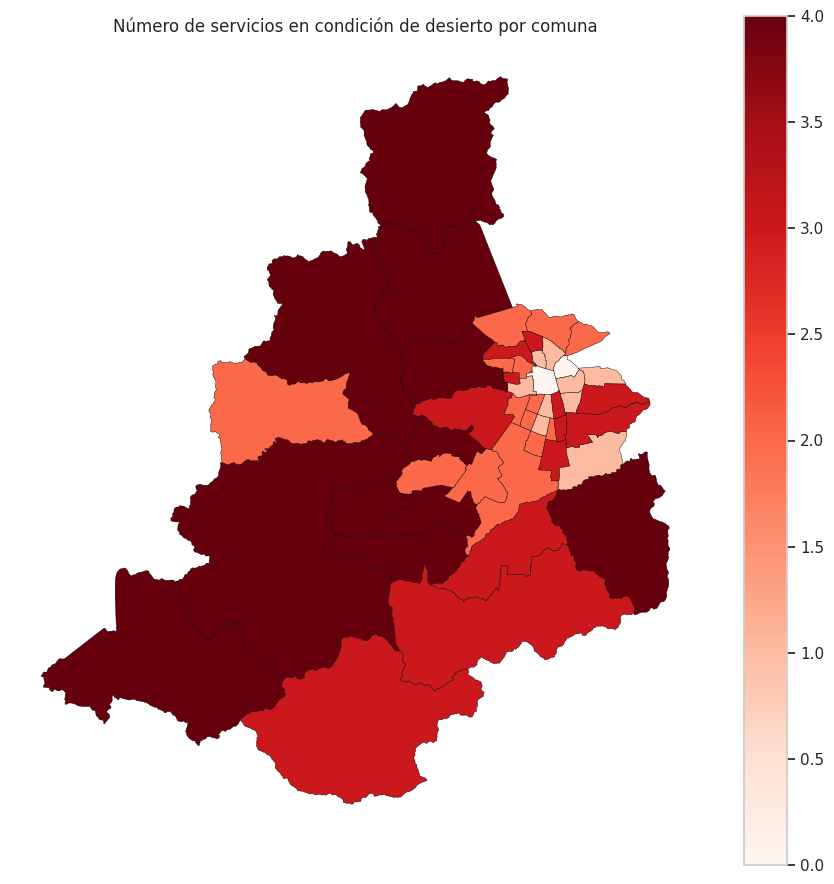

Comunas: 52 | Tabla: 48
IDs tabla NO en comunas: set()


In [9]:
comunas_map = comunas.merge(
    tabla[["cod_comuna", "n_servicios_en_desierto", "cluster"]],
    on="cod_comuna",
    how="left"
)

fig, ax = plt.subplots(figsize=(9, 9))
comunas_map.plot(
    column="n_servicios_en_desierto",
    ax=ax,
    legend=True,
    cmap="Reds",
    edgecolor="black",
    linewidth=0.3
)

ax.set_title("Número de servicios en condición de desierto por comuna", fontsize=12)
ax.set_axis_off()
plt.tight_layout()
save_figure(fig, "sintesis_mapa_indice_desiertos")
plt.show()

print("Comunas:", comunas["cod_comuna"].nunique(), "| Tabla:", tabla["cod_comuna"].nunique())
print("IDs tabla NO en comunas:", set(tabla["cod_comuna"]) - set(comunas["cod_comuna"]))


💾 Figura guardada en: /home/jovyan/outputs/figures/sintesis_barra_top_desiertos.png


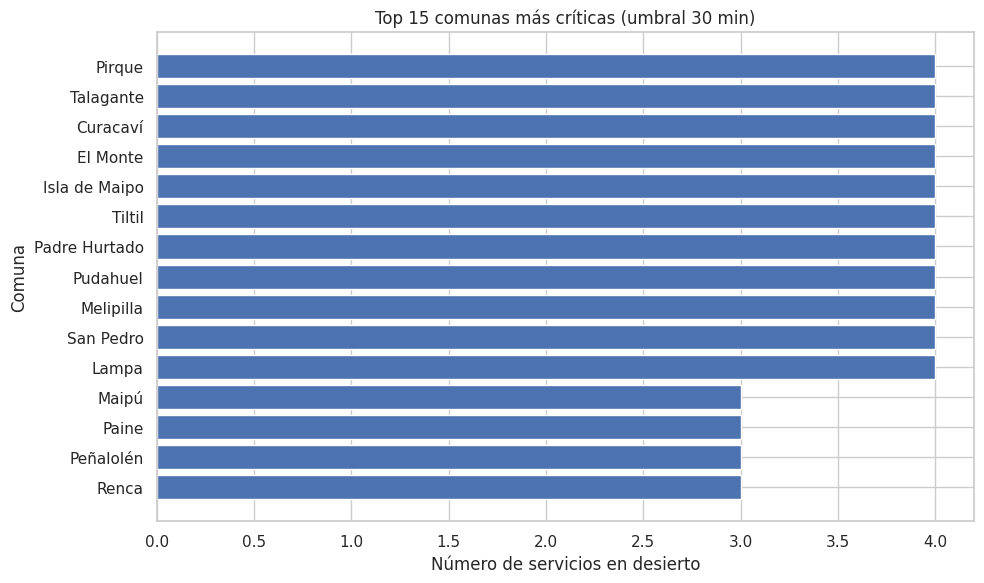

In [10]:
top_n = 15
top_plot = top_desiertos.head(top_n).sort_values("n_servicios_en_desierto")

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(top_plot["comuna"], top_plot["n_servicios_en_desierto"])
ax.set_xlabel("Número de servicios en desierto")
ax.set_ylabel("Comuna")
ax.set_title(f"Top {top_n} comunas más críticas (umbral {THRESH_MIN:.0f} min)")

plt.tight_layout()
save_figure(fig, "sintesis_barra_top_desiertos")
plt.show()


In [11]:
tabla_final_path = OUTPUTS_DIR / "tabla_final_desiertos_servicios.csv"
tabla.to_csv(tabla_final_path, index=False)
print("✅ Exportado:", tabla_final_path)


✅ Exportado: /home/jovyan/outputs/tabla_final_desiertos_servicios.csv
